
# Transfer Learning

## Using the VGG16 [ImageNet](https://www.image-net.org/) weights to retrain a model

In this notebook, we adopt the structure and weight number of the **VGG16** convolutional neural network pretrained using the *ImageNET* sample. The last two fully connected layers are removed and replace by a set of fresh fully connected layers.

- We freeze all the weight number of the original VGG16 network and only let the fully connected section to participate in the training process.

- VGG16 takes 224x224 images as input. We have already generated the augmented sample of 128x128 galaxies, and therefore we need to add extra zero padding around our sample images to make them compatible with the VGG16 structure. Another approach might be to prepare another sample of 224x224 images from our original 512x512 galaxy images, however we don't pursue that approach here.

![VGG16 Architecture](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)
[figure source](https://neurohive.io/en/popular-networks/vgg16/)

## Importing packages

In [21]:
import sys, os, gc
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import random
from datetime import datetime
import json
import imgaug as ia
import imgaug.augmenters as iaa
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical

## Importing the VGG16 model

The VGG16 model comprises of 16 convolutional layers divided into 4 sections, each of which has 3 convolutional and 1 Max pooling layer. The convolution filters are of shape 3x3.

![VGG16](https://neurohive.io/wp-content/uploads/2018/11/vgg16.png)
[figure source](https://neurohive.io/en/popular-networks/vgg16/)

In [22]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras import applications
from tensorflow.keras.models import Model

In [24]:
MODEL = applications.vgg16.VGG16(include_top=True, weights='imagenet')

## we fix the weight values of all layers, as we don't tend to train the convolutional part
MODEL.trainable = False

import pandas as pd
layers = [(layer, layer.name, layer.trainable) for layer in MODEL.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_6,False
1,<tensorflow.python.keras.layers.convolutional....,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional....,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPoo...,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional....,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional....,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPoo...,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional....,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional....,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional....,block3_conv3,False


## Examining the imported VGG16 model 

We exclude the last 4 fully connected layers.

In [25]:
model = Sequential()
for layer in MODEL.layers[:-4]: # the laste 4 fully connected layers from copying
    model.add(layer)
    
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

## Model definition

Here, we officially construct our model. The convolutional part is exactly the same as what we have in VGG16 and all convolutional weights are not trainable. The fully connected layers are customized for our problem and all its weights are adjustable in the training process.

Since we are just dealing with galaxies which are different than the [ImageNet](https://www.image-net.org/) sample, in shape and structure, we use a simpler fully connected layers with less number of trainable parameters.

In [6]:
def vgg():

    MODEL = applications.vgg16.VGG16(include_top=True, weights='imagenet')
    MODEL.trainable = False
    
    # Adding the convolutional layers of VGG16 layer by layer
    model = Sequential()
    for layer in MODEL.layers[:-4]: # just exclude last layer from copying
        model.add(layer)

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dense(8, activation='relu'))

    # output layer
    model.add(tf.keras.layers.Dense(1, activation='tanh', name='fc_out2'))

    return model

def esn_shuffle(array, seed=0):
        np.random.seed(seed)
        np.random.shuffle(array)
        return array

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)


## The summary of our customized model

In [7]:
model = vgg()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

### A customized shuffling function to randomize the input arrays

In [8]:
def esn_shuffle(array, seed=None):
        if seed is not None:
            np.random.seed(seed)
        np.random.shuffle(array)
        return array

### Augmentations for the test images

In [9]:
seq = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.1))),
    iaa.GammaContrast(gamma=(0.97,1.03)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 3), per_channel=0.5),
    iaa.Add((-5, 5), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.5),
    iaa.Sometimes(0.1, iaa.Grayscale(alpha=(0.0, 1.0))),
    iaa.Sometimes(0.50, iaa.Grayscale(alpha=1.)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(
        rotate=(0, 359),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, 
        mode=ia.ALL, cval=(0, 255))
    ], random_order=True)


seqGray = iaa.Sequential([
    iaa.GammaContrast(gamma=(0.97,1.03)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(
        rotate=(0, 359),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, 
        mode=ia.ALL, cval=(255, 255))
    ], random_order=True)

### Importing text images

`samples/<filter>_128x128_test_000.npz` have not been already augmented. Therefore we augment them in the same way we prepared the training sample.

In [10]:
%%time 

data = np.load('samples/RGB_128x128_test_000.npz')
images_RGB = data['images'].astype(np.uint8)
labels_RGB = data['labels'] 
pgcIDs_RGB = data['pgcIDs']
N = images_RGB.shape[0]
filter_RGB = np.chararray(N)
filter_RGB[:] = 'c'
data.close() 
del data


data = np.load('samples/g_128x128_test_000.npz')
images_g = data['images'].astype(np.uint8)
labels_g = data['labels'] 
pgcIDs_g = data['pgcIDs']
N = images_g.shape[0]
filter_g = np.chararray(N)
filter_g[:] = 'g'
data.close() 
del data

data = np.load('samples/r_128x128_test_000.npz')
images_r = data['images'].astype(np.uint8)
labels_r = data['labels'] 
pgcIDs_r = data['pgcIDs']
N = images_r.shape[0]
filter_r = np.chararray(N)
filter_r[:] = 'r'
data.close() 
del data

data = np.load('samples/i_128x128_test_000.npz')
images_i = data['images'].astype(np.uint8)
labels_i = data['labels'] 
pgcIDs_i = data['pgcIDs']
N = images_i.shape[0]
filter_i = np.chararray(N)
filter_i[:] = 'i'
data.close() 
del data

CPU times: user 2.43 s, sys: 386 ms, total: 2.81 s
Wall time: 3.82 s


### Concatenating the gray test images taken at g, r, and i bands

In [11]:
images_gri = np.concatenate((images_g, images_r, images_i))
labels_gri = np.concatenate((labels_g, labels_r, labels_i))
pgcIDs_gri = np.concatenate((pgcIDs_g, pgcIDs_r, pgcIDs_i))
filter_gri = np.concatenate((filter_g, filter_r, filter_i))

N_RGB = len(labels_RGB)
N_gri = len(labels_gri)

Here, we shuffle `gri` images and then we randomly invert half of them. In this way half of the galaxy images have black background and the other half have white background.

In [12]:
ia.seed(100)

indx = esn_shuffle(np.arange(N_gri), seed=200)
images_aug = seqGray(images=images_gri[indx][:N_RGB,:,:,:])
labels_aug = labels_gri[indx][:N_RGB]
pgcIDs_aug = pgcIDs_gri[indx][:N_RGB]
filter_aug = filter_gri[indx][:N_RGB]

n = len(images_aug)
p = int(n/2)
images_aug[:p] = 255 - images_aug[:p]

ia.seed(200)

images_aug = np.concatenate((seq(images=images_RGB),images_aug))
labels_aug = np.concatenate((labels_RGB,labels_aug))
pgcIDs_aug = np.concatenate((pgcIDs_RGB,pgcIDs_aug))
filter_aug = np.concatenate((filter_RGB,filter_aug))

indx = np.arange(len(images_aug))
indx = esn_shuffle(indx, seed=100)
images_test_aug = images_aug[indx]
labels_test_aug = labels_aug[indx]
pgcIDs_test_aug = pgcIDs_aug[indx]
filter_test_aug = filter_aug[indx]

# inclinations are mapped to range between -1 and 1, compatibale with the tanh outputs
labels_test_aug = 2.*(labels_test_aug-45.)/45. - 1.

The resolution of images in our sample is 128x128. So we add extra zero padding around images to enlarge them into 224x224.

In [13]:
images_test_aug.shape

(3314, 128, 128, 3)

## An example of a padded image

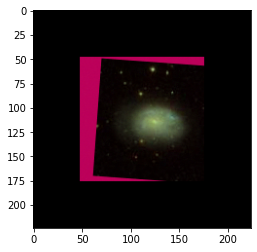

In [14]:
N, _, _, _ = images_test_aug.shape
images_224x224 = np.zeros((N, 224, 224, 3), dtype=np.dtype('>i4'))
images_224x224[:,48:176,48:176, :] = images_test_aug
images_test_aug = images_224x224
del images_224x224

plt.imshow(images_test_aug[30])

### Batch number generation

We have 50 batches of training data, each stored in a separate `npz` file on the disk.
Each grand Epoch includes all 50 random iterations that cover the entire training sample. Within each epoch, batches are fed to the network in different orders.
Below, we generate 60 grand epochs of 50 small iterations. Each iteration covers one training sub-sample in `npz` format.

In [15]:
batches = esn_shuffle(np.arange(50), seed=20)

for i in range(1,60):
    batches = np.concatenate((batches, esn_shuffle(np.arange(50), seed=i*20))) 

batches, len(batches)

(array([12, 14,  4, ..., 14, 15, 45]), 3000)

## Training Process

- *zp_dir:* Folder that contains all 50 training batches in `npz` format
- *ckpt_dir:* Folder to save the weight numbers of the network after each iteration


Advancing the training process at each step consists of

1.  Reconstruction of the model as it is at the end of the previous step
2.  Reading the `npz` file that holds the corresponding batch
3.  Training the model for one epoch (moving forward just for 1 iteration)
4.  Updating the JSON file that contains the desired network metrics
5.  Saving the weight values of the model for the use in the next iteration



In [16]:
zp_dir = 'Uset0_npz/'
ckpt_dir = 'U0_model08_ckpt/'

def trainer(iter, batches, suffix=None):

  if suffix is None:
    suffix = ''

  batchNo = batches[iter]
  if True: 
    
    ## initializing the model in the beginning of each iteration
    vgg_model = vgg()
    vgg_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae'])

    if iter>0:
      
      vgg_model = vgg()
      vgg_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae'])
    
      ## if we are in  the middle of the training process, we load the weight number of the network 
      ## produced in the previous step
      vgg_model.load_weights(ckpt_dir+str(iter-1)+suffix+".ckpt")

      ## The networks performance metrics are stored in JSON and is updated at each step
      with open(ckpt_dir+'evalDict'+suffix+'.json') as json_file:
        evalDict = json.load(json_file)
    else:
      evalDict = {}


    print("iter #{}".format(iter))
    print("Batch number: {}".format(batchNo))

    
    # reading out the training batch from disk
    batchFile = npzname = '128x128_train_aug_'+'%02d'%(batchNo+1)+'.npz'
    data = np.load(zp_dir + batchFile)
#     images_train_aug = data['images'].astype(np.uint8)
    
#     N, _, _, _ = images_train_aug.shape
#     print(images_train_aug.shape)
    images_train_aug = np.zeros((10000, 224, 224, 3), dtype=np.dtype('>i4'))
    images_train_aug[:,48:176,48:176, :] = data['images'].astype(np.uint8)[:10000]
#     images_train_aug = images_224x224
#     del images_224x224

    labels_train_aug = data['labels']
    pgcIDs_train_aug = data['pgcIDs']
    data.close() 
    del data
    
    # mapping out the labels to lie between -1 and 1
    labels_train_aug = 2.*(labels_train_aug-45.)/45. - 1.
    
    n_epochs=1
    vgg_model.fit(images_train_aug, labels_train_aug[:10000], 
                                      epochs=n_epochs, batch_size=128, 
                                      validation_data=(images_test_aug, labels_test_aug),
                                      verbose=1, shuffle=True)
    
    # updating the JSON file that holds all metrics
    evalDict[iter] = {} 
    for key in vgg_model.history.history:
      evalDict[iter][key] = vgg_model.history.history[key][0]
    evalDict[iter]["batchNo"] = batchNo
    evalDict[iter]["batchFile"] = batchFile
    
    with open(ckpt_dir+"evalDict"+suffix+".json", "w", encoding ='utf8') as outfile:
      json.dump(evalDict, outfile, allow_nan=True, cls=NpEncoder)
    
    
    ## Taking an snapshot of the network to be used in the proceeding iteration
    vgg_model.save_weights(ckpt_dir+str(iter)+suffix+".ckpt")

    del vgg_model
    tf.keras.backend.clear_session()
    del images_train_aug 
    del labels_train_aug
    del pgcIDs_train_aug

    gc.collect()

    return evalDict

### Training the network until no further improvements can be achieved

or until achieving convergence.

If the training process doesn't improve the evaluations metrics on the test (evaluation) set, we stop the training process. 

In [17]:
with tf.device('/gpu:0'):
    for i in range(0, 500):
        trainer(i, batches)

iter #310
Batch number: 12
79/79 [==============================] - 91s 885ms/step - loss: 0.0413 - mse: 0.0413 - mae: 0.1527 - val_loss: 0.0567 - val_mse: 0.0567 - val_mae: 0.1701
iter #311
Batch number: 21
79/79 [==============================] - 51s 643ms/step - loss: 0.0421 - mse: 0.0421 - mae: 0.1550 - val_loss: 0.0569 - val_mse: 0.0569 - val_mae: 0.1701
iter #312
Batch number: 32
79/79 [==============================] - 51s 643ms/step - loss: 0.0411 - mse: 0.0411 - mae: 0.1515 - val_loss: 0.0548 - val_mse: 0.0548 - val_mae: 0.1687
iter #313
Batch number: 5
79/79 [==============================] - 51s 644ms/step - loss: 0.0409 - mse: 0.0409 - mae: 0.1504 - val_loss: 0.0566 - val_mse: 0.0566 - val_mae: 0.1697
iter #314
Batch number: 27
79/79 [==============================] - 52s 658ms/step - loss: 0.0431 - mse: 0.0431 - mae: 0.1547 - val_loss: 0.0593 - val_mse: 0.0593 - val_mae: 0.1789
iter #315
Batch number: 49
79/79 [==============================] - 51s 643ms/step - loss: 0.041

## Plotting the evaluation metrics

The following analysis is constantly performed to monitor the behavior of the network as it trains. 

In [17]:
import pandas as pd

with open(ckpt_dir+"evalDict.json") as json_file:
        evalDict = json.load(json_file)

df =  pd.DataFrame.from_dict(evalDict).T   

df.tail()

,loss,mse,mae,val_loss,val_mse,val_mae,batchNo,batchFile
495,0.0363477,0.0363477,0.143239,0.0603462,0.0603462,0.174607,5,128x128_train_aug_06.npz
496,0.037682,0.037682,0.146266,0.0599022,0.0599022,0.173195,29,128x128_train_aug_30.npz
497,0.0368696,0.0368696,0.144449,0.0646,0.0646,0.183983,11,128x128_train_aug_12.npz
498,0.0385604,0.0385604,0.147271,0.0682263,0.0682263,0.183042,22,128x128_train_aug_23.npz
499,0.0372543,0.0372543,0.144647,0.0592049,0.0592049,0.175574,49,128x128_train_aug_50.npz


After about 100 iterations, the training and testing metrics detach from each other, meaning the training process not longer produces reliable results.

Note that the results of this network is NOT better than our fully developed CNNs (models 4, 5, and 6).
In all of those models the ultimate values of RMSE and MAE are better than 0.05 and 0.125 (deg), respectively, while with the current network these metrics are worse than out expectation.

There might be the case that the transferred information from the convolutional layers of VGG16 doesn't perfectly suite our problem. Allowing some of the convolutional layers to be trainable might help with the situation, however the number of trainable parameters would be much bigger in that case that contradicts the purpose of the transfer learning process, which is to reduce the training time with lesser available computational resources. 

(0.1, 0.3)

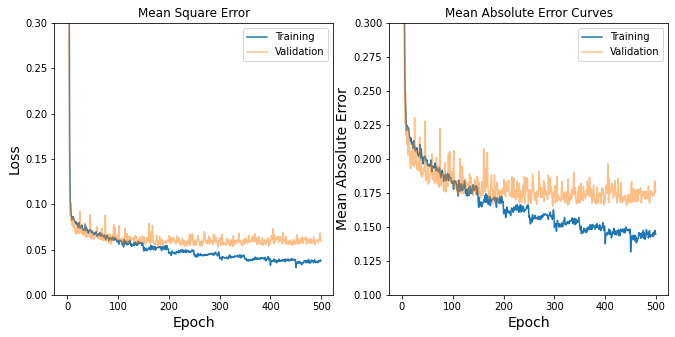

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11,5))

epochs = np.arange(len(df))

ax[0].plot(epochs, df.mse.values, label='Training')
ax[0].plot(epochs, df.val_mse, label='Validation', alpha=0.5)
ax[0].set_title('Mean Square Error')
ax[0].legend()
ax[0].set_xlabel('Epoch', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].set_ylim(0, 0.3)

ax[1].plot(epochs, df.mae.values, label='Training')
ax[1].plot(epochs, df.val_mae, label='Validation', alpha=0.5)
ax[1].set_title('Mean Absolute Error Curves')
ax[1].legend()
ax[1].set_xlabel('Epoch', fontsize=14)
ax[1].set_ylabel('Mean Absolute Error', fontsize=14)
ax[1].set_ylim(0.1, 0.3)

# Conclusion: the performance of the trained network is no better than our original models

In following cells, we repeat the same process of examining the results. Clearly all performance metrics of the adapter VGG16 are not better than our previous results. However, if one is looking for getting a descent model by avoiding a long training time, this model is a good replacement, although this is not in favor of our project objectives. 

## Predictions vs. Actual measurements

We cross compare the evaluated inclinations versus the actual labels.

To get better understanding of the model performance, we plot the difference between the evaluated inclinations and the measured values by users ($\Delta i-i_m-i_p$). In the following plot, the horizontal axis shows the measured inclinations. Each point represents a galaxy in the test sample.

- **Left Panel:** Predicted values $i_p$, are directly generated by applying the trained network on the test sample. Red sold line displays the results of a least square linear fit on the blue points. Evidently, there is a inclination dependent bias that is inclination dependent. This bias has been linearly modeled by the red line, which is utilized to adjust the predicted values. The slope and intercept of the fitted line are encoded in the $m$ and $b$ parameters.
- **Right Panel:** Same as the left panel, with adjusted predictions, $i_{pc}$, that is calculated using $i_{pc}= \frac{i_p+b}{1-m}$.

**Note:** The root mean square of the prediction$-$measurements differences is $~4^o$. The similar metric is $~2.6^o$ when we compare the measured values of two groups of the human users. This means our model is slightly performs worst than human, and most of that poor performances is attributed to the outliers and features (like data noise, point sources, stellar spikes, poor images, etc.) with no enough data coverage.

The performance of the trained network is slightly worse than our prototype ($~3^o$), because augmentation introduces a lot of different possibilities that requires a large sample and many more iterations to achieve the same goal. In the prototype model, we adopted 64x64 images, and all galaxies where aligned horizontally, whereas in the full augmented analysis, galaxies are left to have arbitrary position angles. This adds to the complexity of the problem.

Raw RMS:  5.4747152888942825
Adjusted RMS:  5.752512285945591


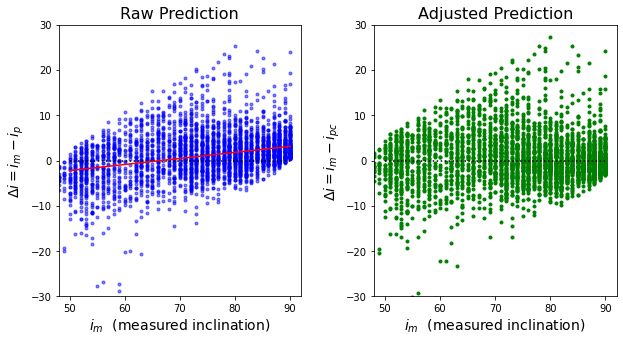

In [19]:
with tf.device('/gpu:0'):    
    vgg_model = vgg()
    vgg_model.load_weights(ckpt_dir+"499.ckpt")

    inc_p = vgg_model.predict(images_test_aug)
    inc_m = 0.5*(labels_test_aug+1.)*45.+45.

    N = images_test_aug.shape[0]
    inc_p = inc_p.reshape(N)
    inc_p = 0.5*(inc_p+1.)*45.+45.


    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 
    
    
    d = inc_m-inc_p
    
    ix = ((d<12)&(d>-12))

    m, b = np.polyfit(inc_m[ix], d[ix], 1)
    x = np.linspace(50,90,20)
    y  = m*x+b

    ax[0].plot(inc_m, d, 'b.', alpha=0.5)
    ax[0].plot([50,90],[0,0], 'k:')
    ax[0].plot(x, y, 'r-')
    ax[0].set_xlim(48,92)
    ax[0].set_ylim(-30 ,30)
    ax[0].set_title('Raw Prediction', fontsize=16)
    ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
    ax[0].set_ylabel(r'$\Delta i = i_m-i_p$', fontsize=14)

    print("Raw RMS: ", np.sqrt(np.mean((d)**2)))

    inc_p2 = (inc_p+b)/(1.-m)
#     inc_p2[(inc_p2>90)] = 90

    d_ = inc_m-inc_p2
    ax[1].plot(inc_m, d_, 'g.')
    ax[1].plot([50,90],[0,0], 'k:')
    ax[1].set_xlim(48,92)
    ax[1].set_ylim(-30,30)

    print("Adjusted RMS: ", np.sqrt(np.mean((d_)**2)))
    ax[1].set_title('Adjusted Prediction', fontsize=16)
    ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
    ax[1].set_ylabel(r'$\Delta i = i_m-i_{pc}$', fontsize=14)

    plt.subplots_adjust( wspace=0.3)

## Visualizing the outliers

Here, we show the first 49 galaxy images in the test sample, where the predicted value is far from the actual measurements, i.e. $\Delta i > 10^o$.

In each panel, cyan label is the galaxy ID in the Principal Galaxy Catalog (PGC), and green and red labels represent the measured and the predicted inclinations. Magenta labels denote the panel numbers.

Some cases are interesting:

1. In panel #42, the galaxy image has been masked out because of the bright center of the galaxy has saturated the image at the center.
2. Case #26 is a typical case, where the galaxy image has been projected next to a bright star.
3. Cases like #2, #14, #23, #29, #43 have poor quality images.
4. Case #37 has been ruined in the data reduction process, when the telescope data has been preprocessed.

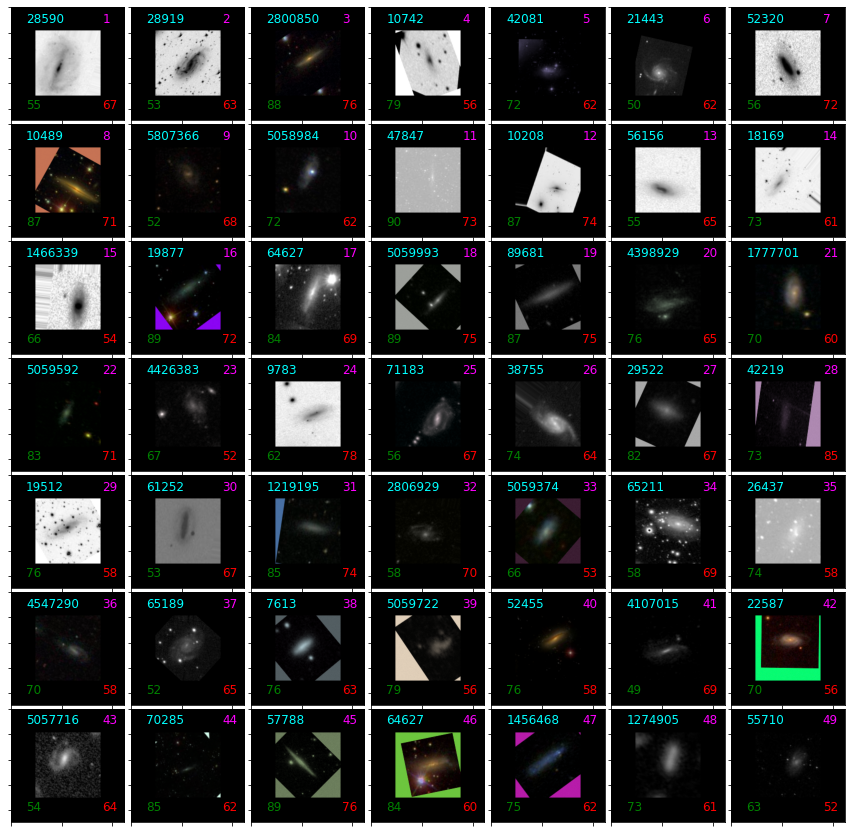

In [20]:
n = 7
m = 7

fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(15,15)) 

t = 0 
ii = 1
delta = np.abs(inc_m[t]-inc_p[t])
for i in range(n):
    for j in range(m):
        
        while t<len(inc_m) and delta < 10:
          t += 1
          delta = np.abs(inc_m[t]-inc_p[t])
        ax = axes[i][j]
        ax.imshow(images_test_aug[t,:,:])

        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)

        ax.text(30, 200, "%.0f"%inc_m[t], color='green', fontsize=12)
        ax.text(180, 30, ii, color='magenta', fontsize=12); ii+=1
        ax.text(180, 200, "%.0f"%inc_p[t], color='red', fontsize=12)
        ax.text(30, 30, pgcIDs_test_aug[t], color='cyan', fontsize=12)

        t+=1
        delta = np.abs(inc_m[t]-inc_p[t])

plt.subplots_adjust(hspace=0.03, wspace=0.03)

# Summary

We adopted the convolutional layers of the VGG16 that has been trained using the [ImageNet](https://www.image-net.org/) dataset. We kept the convolutional layers unchanged by setting their trainablity attribute to `false`. Removing the last fully connected layers, we introduced our customized fully connected layers. We trained the fully connected part to fit our sample galaxies. It turned out that the new structure is trainable to some extent, however its performance is not better than our original network designs. We suggest to allow a couple of the convolutional layers to be readjusted in order to get better fits, however this might not be the case in the end, according to the number of additional weights that need to be trained, as well as the small size of our training sample. We can improve the training sample size by adding more augmentations, however this increases the training time and requires us to leverage more computational resources that is not justifiable while our original models are cheaper to train and much simpler and produce more precise predictions. 